<a href="https://colab.research.google.com/github/Des-PM/DA/blob/main/ROC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [53]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from imblearn.over_sampling import SMOTE
from scipy.stats import pointbiserialr

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay



## Data Sourcing

In [31]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle 

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download shashwatwork/dataco-smart-supply-chain-for-big-data-analysis
!unzip /content/dataco-smart-supply-chain-for-big-data-analysis.zip

 35% 9.00M/25.7M [00:00<00:00, 92.3MB/s]
100% 25.7M/25.7M [00:00<00:00, 138MB/s] 
Archive:  /content/dataco-smart-supply-chain-for-big-data-analysis.zip
  inflating: DataCoSupplyChainDataset.csv  
  inflating: DescriptionDataCoSupplyChain.csv  
  inflating: tokenized_access_logs.csv  


In [32]:
df = pd.read_csv('/content/DataCoSupplyChainDataset.csv',encoding='latin-1')
print(df.head(5))
print(df.shape)

       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goo

## Data Cleaning: Data Extraction, Transformation and Cleaning

In [33]:
null_columns = df.columns[df.isna().any()] # check NaN values
print('Columns with NaN values are:' , null_columns) # printing column names containing NaN
# removing the coumns having NaN values
df = df.drop(columns = null_columns, axis=1)
print(df.info())

Columns with NaN values are: Index(['Customer Lname', 'Customer Zipcode', 'Order Zipcode',
       'Product Description'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer

#### Because we will identify customers/departments by their CustomerId/DepartmentId there is no need for the "Customer Lname" "Customer Fname" and "Department Name" columns.

In [34]:
print(pd.unique(df['Product Status'])) # only contains zeros. no other unique values
# below are the columns in the data which are irrelevant. It contains no information 
irrelevant_info_columns = ["Customer Email", "Customer Fname", 
                          "Customer Password", "Department Name", "Product Image", "Product Status", "Customer Street"]
df = df.drop(columns = irrelevant_info_columns, axis=1)
print(df.info())

[0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Id                    180519 non-null  int64  
 12  Customer Segment          

In [35]:
def check_duplicate_columns(dataframe_test):
    columns_names = []
    
    for ii in list(combinations(dataframe_test.columns, 2)):
        if np.all(dataframe_test[ii[0]] == dataframe_test[ii[1]]):
            columns_names.append(ii)
            print("{} and {} are the same".format(*ii))
    
    return columns_names

                
redundancies = check_duplicate_columns(df)

Benefit per order and Order Profit Per Order are the same
Sales per customer and Order Item Total are the same
Category Id and Product Category Id are the same
Customer Id and Order Customer Id are the same
Order Item Cardprod Id and Product Card Id are the same
Order Item Product Price and Product Price are the same


Hence, we are removing one of the columns which are exactly the same. The removed columns are
**Order Profit Per Order, Order Item Total, Product Category Id, Order Customer Id, Order Item Cardprod Id, Order Item Product Price**

In [36]:
duplicate_cols_to_remove = ["Order Profit Per Order", "Order Item Total", "Product Category Id", 
                            "Order Customer Id", "Order Item Cardprod Id", "Order Item Product Price"]
df = df.drop(columns = duplicate_cols_to_remove, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Id                    180519 non-null  int64  
 12  Customer Segment              

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 <a list of 19 Text major ticklabel objects>)

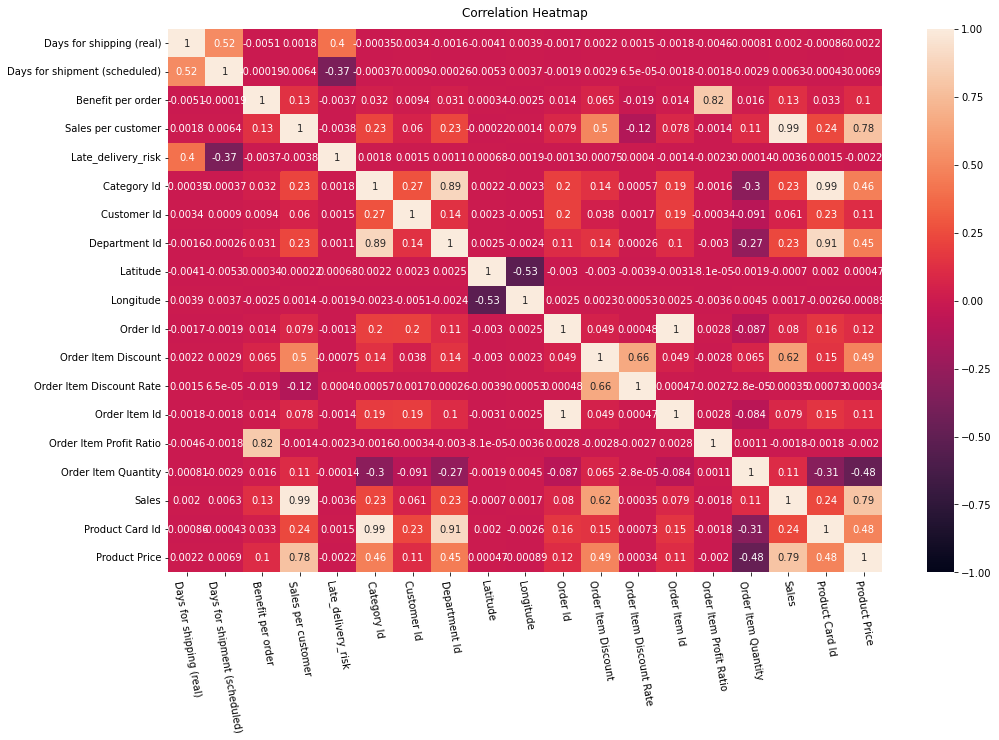

In [ ]:
plt.figure(figsize=(16, 10))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True 
# to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.xticks(rotation=280) 

The correlation coefficient of few columns is very high (> 0.8) i.e., both the columns are providing the same information. 
To reduce the computational complexity, we can remove any one of the columns. the correlation coeeficient values along with the column names are given below:
- **Sales per customer and Sales** = 0.99
- **Benefit per order and Order Item Profit Ratio** = 0.82
- **Department Id and Category Id** = 0.89
- **Department Id and Product Card Id** = 0.91
- **Product Card Id and Category Id** = 0.99

So, we are removing following columns 
1. Sales per customer, 
2. Order Item Profit Ratio, 
3. Department Id, 
4. Product Card Id

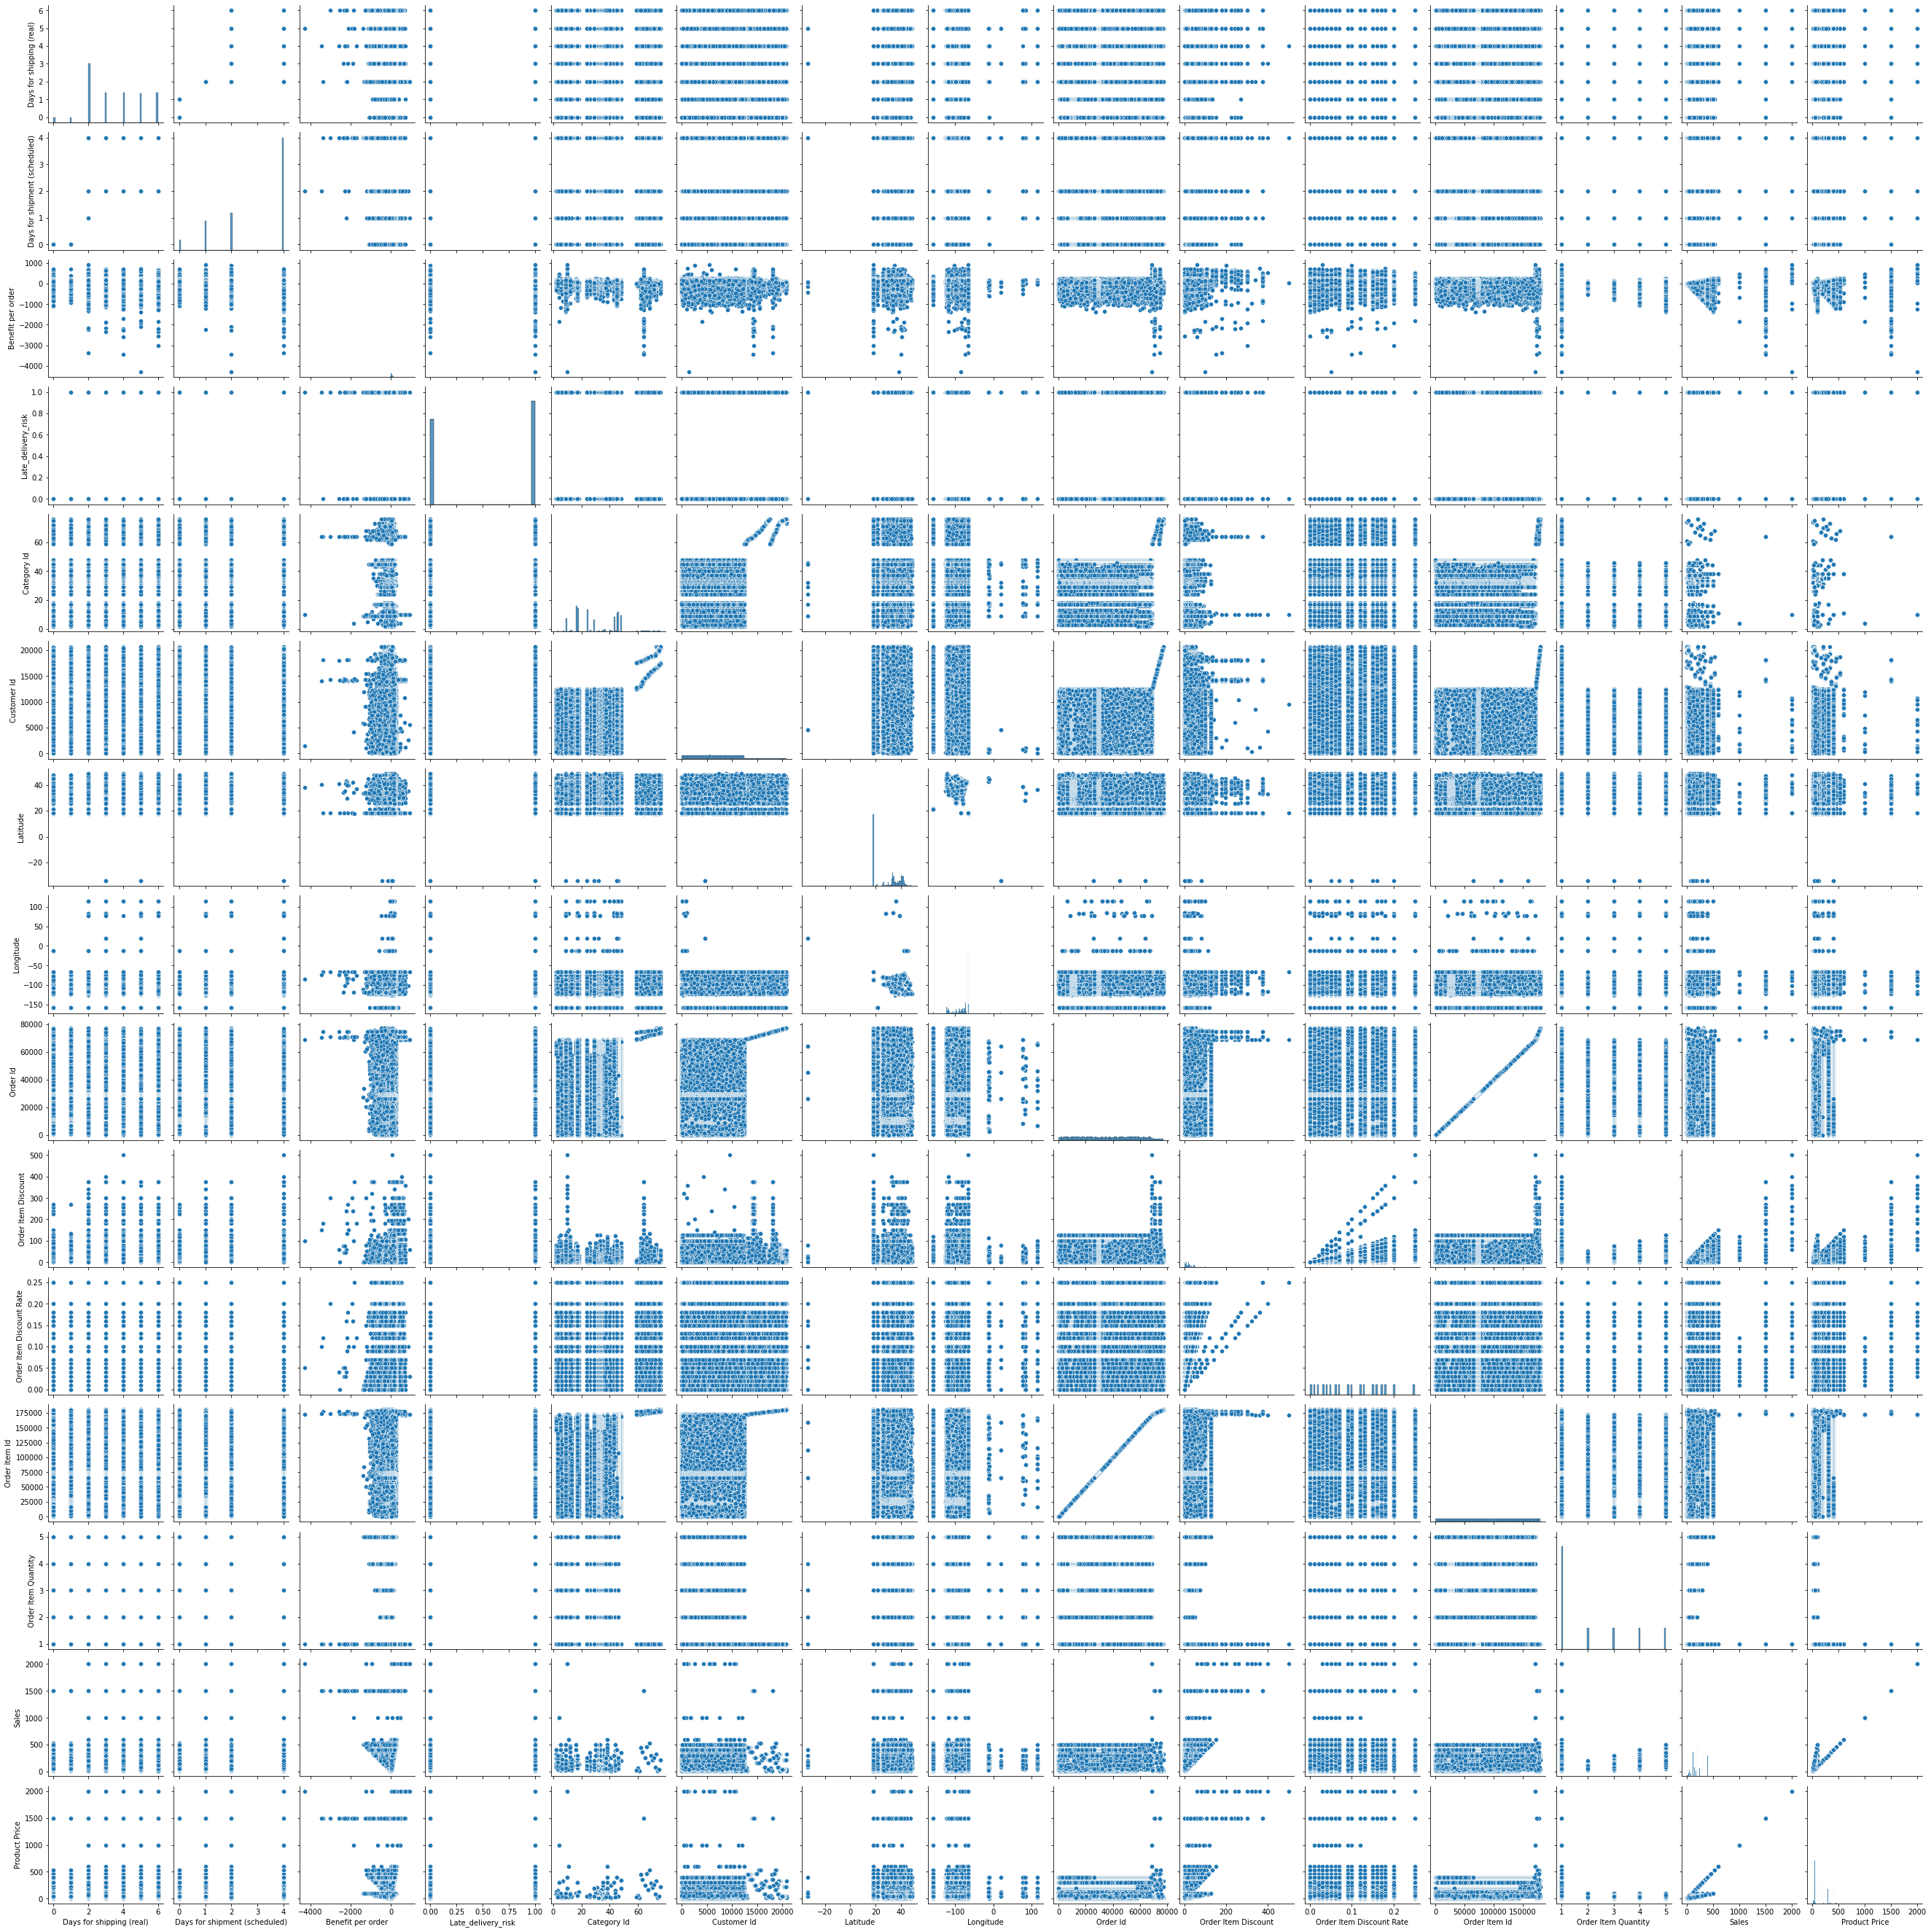

In [ ]:
#Using Seaborn library 
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df)

In [37]:
high_corr_cols_to_remove = ["Sales per customer", "Order Item Profit Ratio", "Department Id", "Product Card Id"]
df = df.drop(columns = high_corr_cols_to_remove, axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Delivery Status                180519 non-null  object 
 5   Late_delivery_risk             180519 non-null  int64  
 6   Category Id                    180519 non-null  int64  
 7   Category Name                  180519 non-null  object 
 8   Customer City                  180519 non-null  object 
 9   Customer Country               180519 non-null  object 
 10  Customer Id                    180519 non-null  int64  
 11  Customer Segment               180519 non-null  object 
 12  Customer State                

## Summary of removed columns:
- **Customer Lname, Customer Zipcode, Order Zipcode, Product Description** -> almost only NaN
- **Product Image** -> no use for analysis
- **Product Category Id, Order Item Cardprod Id, Order Item Product Price, Order Customer Id, Benefit per order, Order Item Total** -> 100% overlap
- **Customer Email, Customer Password, Product Status, Customer Street** -> no relevant information in data
- **Customer Lname, Customer Fname, Department Name** -> no need for them as identifiers (already have Customer/Department Id)
- **Sales per customer, Order Item Profit Ratio, Department Id, Product Card Id** -> Very high correlation

## Data Exploration

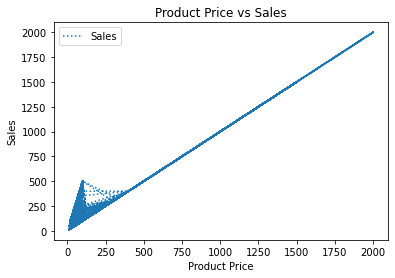

In [ ]:
df.plot(x='Product Price', y='Sales', linestyle='dotted',
     markerfacecolor='green', markersize=12) 
plt.title('Product Price vs Sales')
plt.xlabel('Product Price')
plt.ylabel('Sales')
plt.show()

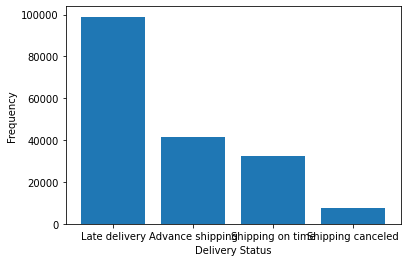

In [ ]:
data_delivery_status=df.groupby(['Delivery Status'])['Order Id'].count().reset_index(name='Number of Orders').sort_values(by= 'Number of Orders', ascending= False)
plt.bar(x = data_delivery_status['Delivery Status'], height = data_delivery_status['Number of Orders'])
plt.xlabel('Delivery Status')
plt.ylabel('Frequency')
plt.show()

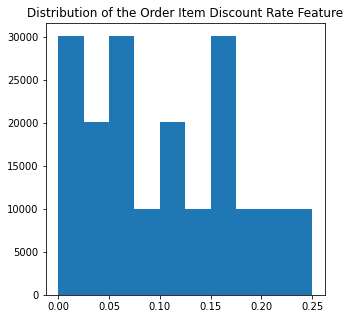

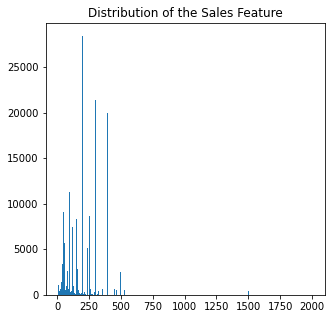

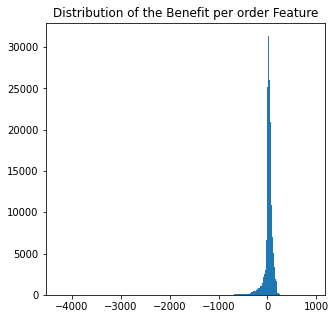

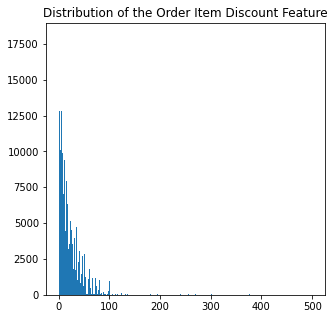

In [ ]:
plt.figure(figsize = ( 5, 5))
plt.hist(df['Order Item Discount Rate'])
plt.title('Distribution of the Order Item Discount Rate Feature')
plt.show()

plt.figure(figsize = ( 5, 5))
plt.hist(df['Sales'], bins = 300)
plt.title('Distribution of the Sales Feature')
plt.show()

plt.figure(figsize = ( 5, 5))
plt.hist(df['Benefit per order'], bins = 300)
plt.title('Distribution of the Benefit per order Feature')
plt.show()

plt.figure(figsize = ( 5, 5))
plt.hist(df['Order Item Discount'], bins = 300)
plt.title('Distribution of the Order Item Discount Feature')
plt.show()

Text(0.5, 1.0, 'Order Item Discount')

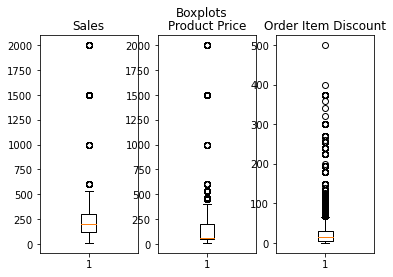

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Boxplots')
ax1.boxplot(df['Sales'])
ax1.set_title('Sales')

ax2.boxplot(df['Product Price'])
ax2.set_title('Product Price')

ax3.boxplot(df['Order Item Discount'])
ax3.set_title('Order Item Discount')

### Transforming Data
#### categorical data of type object is encoded to numeric data using labelencoder

### Using Label encoder all the column with datatype as object is been transformed
**Delivery Status, Category Name, Customer City, Customer Country, Customer Segment, Customer State, Market, Order City, Order Country, Order Region, Order State, Product Name, Shipping Mode, Type**

In [38]:
le = preprocessing.LabelEncoder()
df['Delivery Status'] = le.fit_transform(df['Delivery Status'])
df['Category Name'] = le.fit_transform(df['Category Name'])
df['Customer City'] = le.fit_transform(df['Customer City'])
df['Customer Country'] = le.fit_transform(df['Customer Country'])
df['Customer Segment'] = le.fit_transform(df['Customer Segment'])
df['Customer State'] = le.fit_transform(df['Customer State'])
df['Market'] = le.fit_transform(df['Market'])
df['Order City'] = le.fit_transform(df['Order City'])
df['Order Country'] = le.fit_transform(df['Order Country'])
df['Order Region'] = le.fit_transform(df['Order Region'])
df['Order State'] = le.fit_transform(df['Order State'])
df['Product Name'] = le.fit_transform(df['Product Name'])
df['Shipping Mode'] = le.fit_transform(df['Shipping Mode'])
df['Type'] = le.fit_transform(df['Type'])

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  int64  
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Delivery Status                180519 non-null  int64  
 5   Late_delivery_risk             180519 non-null  int64  
 6   Category Id                    180519 non-null  int64  
 7   Category Name                  180519 non-null  int64  
 8   Customer City                  180519 non-null  int64  
 9   Customer Country               180519 non-null  int64  
 10  Customer Id                    180519 non-null  int64  
 11  Customer Segment               180519 non-null  int64  
 12  Customer State                

### Checking the unique classes present in order status

                     0
CANCELED          3692
CLOSED           19616
COMPLETE         59491
ON_HOLD           9804
PAYMENT_REVIEW    1893
PENDING          20227
PENDING_PAYMENT  39832
PROCESSING       21902
SUSPECTED_FRAUD   4062
['CANCELED' 'CLOSED' 'COMPLETE' 'ON_HOLD' 'PAYMENT_REVIEW' 'PENDING'
 'PENDING_PAYMENT' 'PROCESSING' 'SUSPECTED_FRAUD'] [ 3692 19616 59491  9804  1893 20227 39832 21902  4062]


([<matplotlib.patches.Wedge at 0x7fcb796d18e0>,
 [Text(1.0977301846479284, 0.07062890139896982, 'CANCELED'),
  Text(0.9807828709815739, 0.49806120104776447, 'CLOSED'),
  Text(-0.29954403608977603, 1.0584296719400148, 'COMPLETE'),
  Text(-1.095641260962441, 0.09782753843694757, 'ON_HOLD'),
  Text(-1.0927956736438185, -0.12568856616794197, 'PAYMENT_REVIEW'),
  Text(-0.9656205515140237, -0.5268557207564067, 'PENDING'),
  Text(-0.02872151174594294, -1.0996249700525302, 'PENDING_PAYMENT'),
  Text(0.9532064688139192, -0.5489967466308876, 'PROCESSING'),
  Text(1.097252635755152, -0.0776959029059588, 'SUSPECTED_FRAUD')],
 [Text(0.5987619188988699, 0.03852485530852899, '2.05%'),
  Text(0.5349724750808584, 0.2716697460260533, '10.87%'),
  Text(-0.1633876560489687, 0.5773252756036443, '32.96%'),
  Text(-0.5976225059795132, 0.0533604755110623, '5.43%'),
  Text(-0.5960703674420827, -0.06855739972796834, '1.05%'),
  Text(-0.5267021190076492, -0.28737584768531277, '11.20%'),
  Text(-0.015666279134150

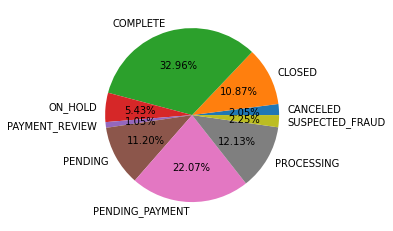

In [39]:
subj_labels, subj_counts = np.unique(df['Order Status'], return_counts = True)
print(pd.DataFrame(subj_counts, subj_labels))

print(subj_labels, subj_counts)

plt.pie(subj_counts, labels = subj_labels, autopct = '%.2f%%')

#### Replacing ['CANCELED' 'CLOSED' 'COMPLETE' 'ON_HOLD' 'PAYMENT_REVIEW' 'PENDING' 'PENDING_PAYMENT' 'PROCESSING' ] categories as 0 and 'SUSPECTED_FRAUD' as 1

[0 1] [176457   4062]


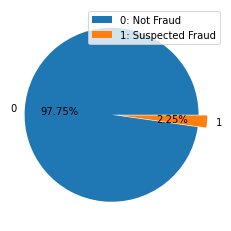

In [40]:
df['Order Status'] = df['Order Status'].replace(['CANCELED', 'CLOSED', 'COMPLETE', 'ON_HOLD', 'PAYMENT_REVIEW', 'PENDING',
 'PENDING_PAYMENT', 'PROCESSING', 'SUSPECTED_FRAUD'],
                                        [0, 0, 0, 0, 0, 0, 0, 0, 1])
new_subj_labels, new_subj_counts = np.unique(df['Order Status'], return_counts = True)
print(new_subj_labels, new_subj_counts)
myexplode = [0.05, 0.05]
plt.pie(new_subj_counts, labels = new_subj_labels, explode = myexplode, autopct = '%.2f%%')
plt.legend(['0: Not Fraud', '1: Suspected Fraud'])

### Correlation between the Target Variable and the Feature space

In [ ]:
r_sales, p_val_sales = pointbiserialr(df['Order Status'], df['Sales'])
print(f"The correlation between order status and Sales = {r_sales:.4f} with the p-value = {p_val_sales:.4f}")

r_ben_order, p_val_ben_order = pointbiserialr(df['Order Status'], df['Benefit per order'])
print(f"The correlation between order status and Benefit per order = {r_ben_order:.4f} with the p-value = {p_val_ben_order:.4f}")

r_ord_dis, p_ord_dis = pointbiserialr(df['Order Status'], df['Order Item Discount'])
print(f"The correlation between order status and Order Item Discount = {r_ord_dis:.4f} with the p-value = {p_ord_dis:.4f}")

r_ord_disrate, p_ord_disrate = pointbiserialr(df['Order Status'], df['Order Item Discount Rate'])
print(f"The correlation between order status and Order Item Discount Rate = {r_ord_disrate:.4f} with the p-value = {p_ord_disrate:.4f}")

r_prodcost, p_prodcost = pointbiserialr(df['Order Status'], df['Product Price'])
print(f"The correlation between order status and Product Price = {r_prodcost:.4f} with the p-value = {p_prodcost:.4f}")

r_shippingdays, p_shippingdays = pointbiserialr(df['Order Status'], df['Days for shipping (real)'])
print(f"The correlation between order status and Days for shipping (real) = {r_shippingdays:.4f} with the p-value = {p_shippingdays:.4f}")

The correlation between order status and Sales = -0.0005 with the p-value = 0.8302
The correlation between order status and Benefit per order = -0.0015 with the p-value = 0.5307
The correlation between order status and Order Item Discount = 0.0009 with the p-value = 0.7139
The correlation between order status and Order Item Discount Rate = 0.0024 with the p-value = 0.3058
The correlation between order status and Product Price = 0.0004 with the p-value = 0.8574
The correlation between order status and Days for shipping (real) = -0.0003 with the p-value = 0.8875


## Applying SMOTE to resample the data

[0 1] [176457 176457]


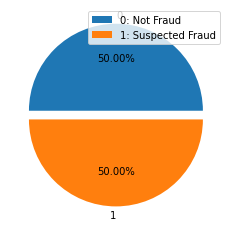

In [43]:
features = df.drop(['Order Status', 'shipping date (DateOrders)', 'order date (DateOrders)'], axis=1)
labels = df['Order Status']

oversample = SMOTE()
features_oversamp, labels_oversamp = oversample.fit_resample(features, labels)

overSamp_subj_labels, overSamp_subj_counts = np.unique(labels_oversamp, return_counts = True)
print(overSamp_subj_labels, overSamp_subj_counts)
myexplode = [0.05, 0.05]
plt.pie(overSamp_subj_counts, labels = overSamp_subj_labels, explode = myexplode, autopct = '%.2f%%')
plt.legend(['0: Not Fraud', '1: Suspected Fraud'])

### Selecting fraction of each Suspected Fraud and non-fraud samples
This is to avoid large processing time in classifier

In [19]:
all_column_names = features_oversamp.columns.insert(len(features_oversamp.columns), 'Order Status')
print(all_column_names)
OverSample_df = pd.concat([features_oversamp, labels_oversamp], axis = 1)#, names = all_column_names)
fraction_to_select = 0.03
OverSample_df_new = OverSample_df.groupby('Order Status').apply(lambda x: x.sample(frac = fraction_to_select))
print(OverSample_df_new.shape)

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Delivery Status', 'Late_delivery_risk',
       'Category Id', 'Category Name', 'Customer City', 'Customer Country',
       'Customer Id', 'Customer Segment', 'Customer State', 'Latitude',
       'Longitude', 'Market', 'Order City', 'Order Country', 'Order Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Quantity', 'Sales', 'Order Region', 'Order State',
       'Product Name', 'Product Price', 'Shipping Mode', 'Order Status'],
      dtype='object')
(10588, 30)


In [20]:
subj_labels, subj_counts = np.unique(OverSample_df_new['Order Status'], return_counts = True)
print(subj_labels, subj_counts)

[0 1] [5294 5294]


In [21]:
features_final = OverSample_df_new.drop('Order Status', axis=1)
labels_final = OverSample_df_new['Order Status']
features_final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10588 entries, (0, 19585) to (1, 219054)
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Type                           10588 non-null  int64  
 1   Days for shipping (real)       10588 non-null  int64  
 2   Days for shipment (scheduled)  10588 non-null  int64  
 3   Benefit per order              10588 non-null  float64
 4   Delivery Status                10588 non-null  int64  
 5   Late_delivery_risk             10588 non-null  int64  
 6   Category Id                    10588 non-null  int64  
 7   Category Name                  10588 non-null  int64  
 8   Customer City                  10588 non-null  int64  
 9   Customer Country               10588 non-null  int64  
 10  Customer Id                    10588 non-null  int64  
 11  Customer Segment               10588 non-null  int64  
 12  Customer State                 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_final, labels_final, test_size=0.33, random_state=42)
print("Shape of the Training Data Features = ", X_train.shape)
print("Shape of the Training Data Labels = ", y_train.shape)
print("Shape of the Testing Data Features = ", X_test.shape)
print("Shape of the Testing Data Labels = ", y_test.shape)

Shape of the Training Data Features =  (7093, 29)
Shape of the Training Data Labels =  (7093,)
Shape of the Testing Data Features =  (3495, 29)
Shape of the Testing Data Labels =  (3495,)


In [24]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
def ML_model_training_testing(ML_model, X_train, y_train, X_test, y_test):
    CrossValid_scores = cross_validate(ML_model, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)

    train_accuracy = np.mean(CrossValid_scores['train_score'])
    cross_val_accuracy = np.mean(CrossValid_scores['test_score'])

    print(f"Train accuracy = {train_accuracy*100:.4f}")
    print(f"Cross validation accuracy= {cross_val_accuracy*100:.4f}")

    # Train classifier on the labelled dataset
    ML_model.fit(X_train, y_train)

    #To plot confusion matrix and finding out precision,recall,accuracy and f1 score.
    y_predict = ML_model.predict(X_test)
    con_mat = confusion_matrix(y_test, y_predict)
    print("Confusion matrix")
    print(con_mat)
    pre = precision_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accu = accuracy_score(y_test, y_predict)
    print(f"Precision = {pre*100}")
    print(f"Accuracy = {accu*100}")
    print(f"F1 Score = {f1*100}")
    print(f"Recall = {rec*100}")
    
    return ML_model, y_predict

# Function to plot ROC curve
def plotROCcurve(y_true, y_predict, classifier_name=""):
    fpr, tpr, thresh = roc_curve(y_true, y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot(color = "blue", label = f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color = "red", lw = 2, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of " + classifier_name +  " Classifier")
    plt.legend(loc="lower right")

## Support Vector Machine

Train accuracy = 99.7243
Cross validation accuracy= 98.7594
Confusion matrix
[[1741   39]
 [   2 1713]]
Precision = 97.77397260273972
Accuracy = 98.82689556509298
F1 Score = 98.8174214017883
Recall = 99.88338192419826


<Figure size 432x288 with 0 Axes>

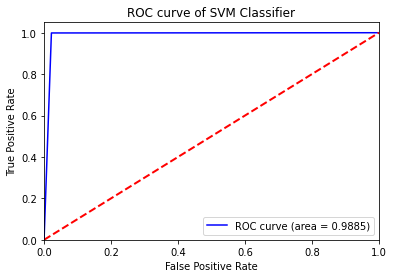

In [27]:
clf_SVM = SVC(C = 10, kernel = 'rbf')
trained_SVM_model, y_predict_SVM = ML_model_training_testing(clf_SVM, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_SVM, classifier_name="SVM")

Train accuracy = 100.0000
Cross validation accuracy= 56.2106
Confusion matrix
[[1780    0]
 [1453  262]]
Precision = 100.0
Accuracy = 58.42632331902718
F1 Score = 26.5048052604957
Recall = 15.276967930029153


<Figure size 432x288 with 0 Axes>

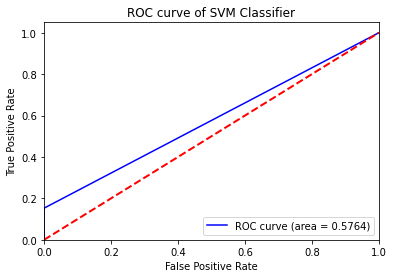

In [ ]:
clf_SVM = SVC(C = 40, gamma = 1e-3)
trained_SVM_model, y_predict_SVM = ML_model_training_testing(clf_SVM, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_SVM, classifier_name="SVM")

## Random Forest

Train accuracy = 100.0000
Cross validation accuracy= 99.0131
Confusion matrix
[[1743   37]
 [   0 1715]]
Precision = 97.88812785388129
Accuracy = 98.94134477825465
F1 Score = 98.93279492356504
Recall = 100.0


<Figure size 432x288 with 0 Axes>

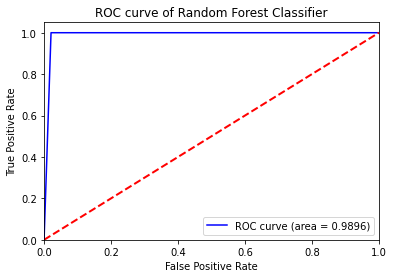

In [28]:
clf_RF = RandomForestClassifier(n_estimators = 300)
trained_RF_model, y_predict_RF = ML_model_training_testing(clf_RF, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_RF, classifier_name="Random Forest")

Train accuracy = 100.0000
Cross validation accuracy= 98.9567
Confusion matrix
[[1760   20]
 [   4 1711]]
Precision = 98.84459849797804
Accuracy = 99.31330472103004
F1 Score = 99.30354033662216
Recall = 99.7667638483965


<Figure size 432x288 with 0 Axes>

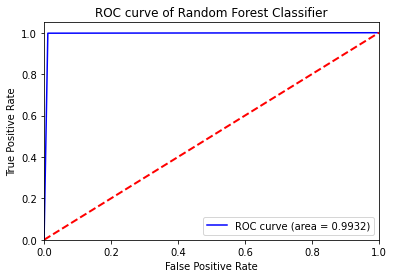

In [ ]:
clf_RF = RandomForestClassifier(n_estimators = 100)
trained_RF_model, y_predict_RF = ML_model_training_testing(clf_RF, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_RF, classifier_name="Random Forest")

## Adaboost

Train accuracy = 99.0507
Cross validation accuracy= 98.9144
Confusion matrix
[[1745   35]
 [   7 1708]]
Precision = 97.99196787148594
Accuracy = 98.79828326180258
F1 Score = 98.78542510121457
Recall = 99.59183673469387


<Figure size 432x288 with 0 Axes>

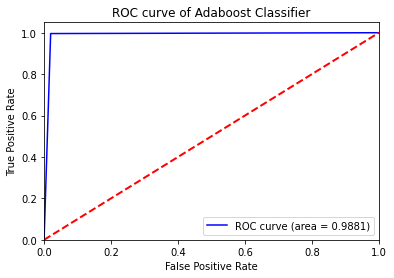

In [29]:
clf_adbst = AdaBoostClassifier(n_estimators=50, random_state=0)
trained_adbst_model, y_predict_adbst = ML_model_training_testing(clf_adbst, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_adbst, classifier_name="Adaboost")

Train accuracy = 98.9708
Cross validation accuracy= 98.9708
Confusion matrix
[[1759   21]
 [   0 1715]]
Precision = 98.79032258064517
Accuracy = 99.39914163090128
F1 Score = 99.39148073022312
Recall = 100.0


<Figure size 432x288 with 0 Axes>

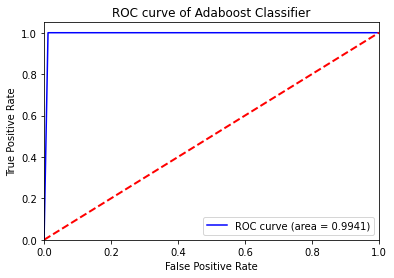

In [ ]:
clf_adbst = AdaBoostClassifier(n_estimators=2, random_state=0)
trained_adbst_model, y_predict_adbst = ML_model_training_testing(clf_adbst, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_adbst, classifier_name="Adaboost")

# Conclusion

In this report, we have used a dataset of supply chains for the analysis of suspected fraud in transaction or not. The data is first cleaned by removing columns with NaN values, columns with no variability or irrelevant information, and duplicate columns containing the same data. Furthermore, one of the columns with a correlation coefficient greater than 0.80 is removed. Due to this, the data becomes less computationally complex and expensive and the overfitting is avoided. Following the removal of these columns, the features with string/categorical datatypes are encoded to convert them to numeric datatypes for further analysis. Because the dataset is highly imbalanced, with only 2.25% of the total data containing suspected fraud samples, the dataset and subsequent classification analysis will be biased, with only one type of data sample classified. As a result, the evaluation metric has a low precision. To deal with this issue, Synthetic Minority Oversampling Technique (SMOTE) is applied which oversamples the less available data samples. This makes both the data samples equal in number. 

Then the data is subjected to various classification models. The data is splitted into 67% training and 33% testing. 10 fold cross validation is employed to avoid overfitting. We have employed support vector machine, random forest and adaboost machine learning (ML) algorithms. These algorithms are compared on the basis of evaluation metric such as precision, recall, F-1 score and ROC curve. Among these ML models, random forest gives best precision, recall, F1 score and area under ROC curve.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features_oversamp, labels_oversamp, test_size=0.33, random_state=42)
print("Shape of the Training Data Features = ", X_train.shape)
print("Shape of the Training Data Labels = ", y_train.shape)
print("Shape of the Testing Data Features = ", X_test.shape)
print("Shape of the Testing Data Labels = ", y_test.shape)

Shape of the Training Data Features =  (236452, 29)
Shape of the Training Data Labels =  (236452,)
Shape of the Testing Data Features =  (116462, 29)
Shape of the Testing Data Labels =  (116462,)


In [45]:
# Normalizing numerical features so that each feature has mean 0 and variance 1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
def ML_model_training_testing(ML_model, X_train, y_train, X_test, y_test):
    CrossValid_scores = cross_validate(ML_model, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)

    train_accuracy = np.mean(CrossValid_scores['train_score'])
    cross_val_accuracy = np.mean(CrossValid_scores['test_score'])

    print(f"Train accuracy = {train_accuracy*100:.4f}")
    print(f"Cross validation accuracy= {cross_val_accuracy*100:.4f}")

    # Train SVM classifier on the labelled dataset
    ML_model.fit(X_train, y_train)

    #To plot confusion matrix and finding out precision,recall,accuracy and f1 score.
    y_predict = ML_model.predict(X_test)
    con_mat = confusion_matrix(y_test, y_predict)
    print("Confusion matrix")
    print(con_mat)
    pre = precision_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    accu = accuracy_score(y_test, y_predict)
    print(f"Precision = {pre*100}")
    print(f"Accuracy = {accu*100}")
    print(f"F1 Score = {f1*100}")
    print(f"Recall = {rec*100}")
    
    return ML_model, y_predict

# Function to plot ROC curve
def plotROCcurve(y_true, y_predict, classifier_name=""):
    fpr, tpr, thresh = roc_curve(y_true, y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr).plot(color = "blue", label = f"ROC curve (area = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color = "red", lw = 2, linestyle = "--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve of " + classifier_name +  " Classifier")
    plt.legend(loc="lower right")

##Random Forest

Train accuracy = 100.0000
Cross validation accuracy= 99.1677
Confusion matrix
[[57454   885]
 [   92 58031]]
Precision = 98.49786136193903
Accuracy = 99.16109975786094
F1 Score = 99.165235519784
Recall = 99.84171498374138


<Figure size 432x288 with 0 Axes>

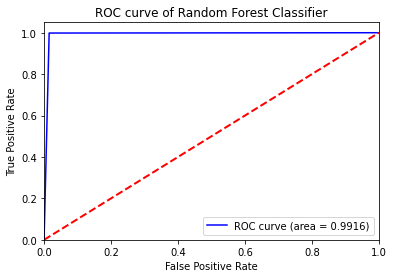

In [47]:
clf_RF = RandomForestClassifier(n_estimators = 300) #'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 120,
trained_RF_model, y_predict_RF = ML_model_training_testing(clf_RF, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_RF, classifier_name="Random Forest")

##Ada Boost

Train accuracy = 98.9655
Cross validation accuracy= 98.9655
Confusion matrix
[[57093  1246]
 [    0 58123]]
Precision = 97.90126160117232
Accuracy = 98.93012313029142
F1 Score = 98.93950226398393
Recall = 100.0


<Figure size 432x288 with 0 Axes>

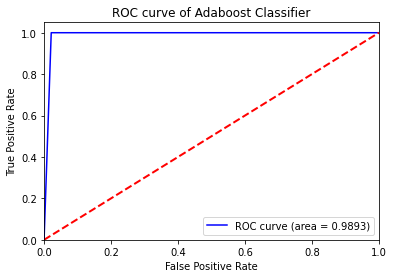

In [48]:
clf_adbst = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
trained_adbst_model, y_predict_adbst = ML_model_training_testing(clf_adbst, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_adbst, classifier_name="Adaboost")

## Support Vector

Train accuracy = 99.6348
Cross validation accuracy= 99.3161
Confusion matrix
[[57529   810]
 [    8 58115]]
Precision = 98.62537123462029
Accuracy = 99.29762497638714
F1 Score = 99.30114141207027
Recall = 99.98623608554273


<Figure size 432x288 with 0 Axes>

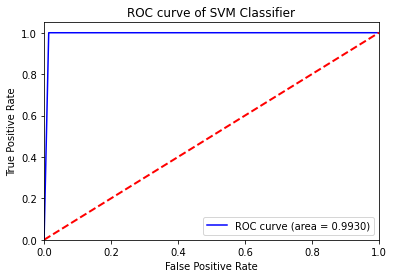

In [56]:
clf_SVM = SVC(C = 10, kernel = 'rbf')
trained_SVM_model, y_predict_SVM = ML_model_training_testing(clf_SVM, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_SVM, classifier_name="SVM")

##XG Boost

In [57]:
from xgboost import XGBClassifier

Train accuracy = 100.0000
Cross validation accuracy= 99.7056
Confusion matrix
[[58085   254]
 [   75 58048]]
Precision = 99.56433741552605
Accuracy = 99.71750442204325
F1 Score = 99.71741464462099
Recall = 99.87096330196307


<Figure size 432x288 with 0 Axes>

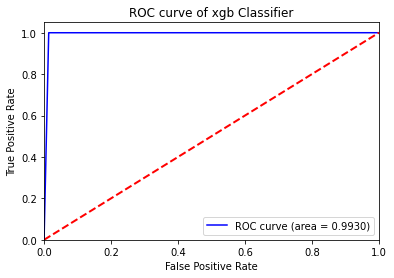

In [58]:

clf_xgb = XGBClassifier(n_estimators=300, learning_rate=0.3, max_depth=7)
trained_xgb_model, y_predict_xgb = ML_model_training_testing(clf_xgb, X_train, y_train, X_test, y_test)
plotROCcurve(y_test, y_predict_SVM, classifier_name="xgb")